<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/transfer-learning/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#tensorflow_version 1.x

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
from skimage.transform import rescale, resize


import pydot

!python -c "import skimage"

OSError: [Errno 12] Cannot allocate memory

try:
    pydot.Dot.create(pydot.Dot())
except:
    print('pydot error')

In [3]:
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.4


In [4]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dense(1024, activation='relu', name='fc7')(x)
#print("Emotions count", len(EMOTIONS))
l=0
for layer in vgg_notop.layers:
    print(layer,"["+str(l)+"]")
    l=l+1
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98]
for i in range(101):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

print('vgg layer 2 is trainable: ' + str(vgg_notop.layers[2].trainable))
print('vgg layer 3 is trainable: ' + str(vgg_notop.layers[3].trainable))

out = Dense(7, activation='softmax', name='classifier')(x)

custom_resnet = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

custom_resnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
plot_model(custom_resnet, to_file='model2.png', show_shapes=True)














<keras.engine.input_layer.InputLayer object at 0x7f787fc0c7b8> [0]
<keras.layers.convolutional.Conv2D object at 0x7f787fc0ca20> [1]
<keras.layers.normalization.BatchNormalization object at 0x7f787fc0ccf8> [2]
<keras.layers.core.Activation object at 0x7f78884f9710> [3]
<keras.layers.pooling.MaxPooling2D object at 0x7f787c18bb70> [4]
<keras.layers.convolutional.Conv2D object at 0x7f787e6e6da0> [5]
<keras.layers.normalization.BatchNormalization object at 0x7f787c1c1cf8> [6]
<keras.layers.core.Activation object at 0x7f787c1c1f28> [7]
<keras.layers.convolutional.Conv2D object at 0x7f787c14ca20> [8]
<keras.layers.normalization.BatchNormalization object at 0x7f787c182748> [9]
<keras.layers.core.Activation object at 0x7f787c14c978> [10]
<keras.layers.convolutional.Conv2D object at 0x7f787c10bfd0> [11]
<keras.layers.convolutional.Conv2D object at 0x7f787c1485f8> [12]
<keras.layers.normalization.BatchNormalization object at 0x7f787c142ef0> [13]
<keras.layers.normalization.BatchNorma

In [1]:
# Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
    # dataset: Data path
def get_data(dataset, pixelsize = 224):
    
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)

    #data = pd.read_csv('fer2013/fer2013.csv')
    data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

    data_train = data[data['Usage'] == 'Training']
    #print('Number samples in the training dataset: ', data_train.shape[0])

    data_dev = data[data['Usage'] == 'PublicTest']
    #print('Number samples in the development dataset: ', data_dev.shape[0])

    # Retrieve train input and target
    X_train, Y_train = data_train['pixels'].tolist(), data_train['emotion'].values
    #print(len(X_train))
    #print(X_train[0])
    # Reshape images to 4D (num_samples, width, height, num_channels)
    X_train = np.array(X_train, dtype='float32').reshape(-1,48,48,1)
    # Normalize images with max (the maximum pixel intensity is 255)
    X_train = X_train/255.0
    #print(X_train.shape)
    #print(X_train[0])
    #image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True)

    # Retrieve dev input and target
    X_dev, Y_dev = data_dev['pixels'].tolist(), data_dev['emotion'].values
    X_dev = np.array(X_dev, dtype='float32').reshape(-1,48,48,1)
    X_dev = X_dev/255.0

    X_dev_res = np.zeros((X_dev.shape[0], pixelsize,pixelsize,3))
    for ind in range(X_dev.shape[0]):  #X_dev.shape[0]
        sample = X_dev[ind]
        sample = sample.reshape(48, 48)
        #plt.imshow(sample, cmap='gray')
        #plt.show()
        image_resized = resize(sample, (pixelsize, pixelsize), anti_aliasing=True)
        X_dev_res[ind,:,:,:] = image_resized.reshape(pixelsize,pixelsize,1)
    #         np.save('X_dev_res.npy', X_dev_res)

    X_train_res = np.zeros((X_train.shape[0], pixelsize,pixelsize,3))
    for ind in range(X_train.shape[0]):  #X_dev.shape[0]
        sample = X_train[ind]
        sample = sample.reshape(48, 48)
        #plt.imshow(sample, cmap='gray')
        #plt.show()
        image_resized = resize(sample, (pixelsize, pixelsize), anti_aliasing=True)
        X_train_res[ind,:,:,:] = image_resized.reshape(pixelsize,pixelsize,1)
    #         np.save('X_train_res.npy', X_train_res)

    Y_train_res = np.zeros((Y_train.size, Y_train.max()+1))
    Y_train_res[np.arange(Y_train.size),Y_train] = 1
    Y_dev_res = np.zeros((Y_dev.size, Y_dev.max()+1))
    Y_dev_res[np.arange(Y_dev.size),Y_dev] = 1
    
    return  X_train_res, Y_train_res, X_dev_res, Y_dev_res

In [ ]:
# Data preparation
train_data_x, train_data_y  = get_data(train_dataset)
val_data  = get_data(eval_dataset)

# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely
# rescale:          Rescaling factor (defaults to None). Multiply the data by the value provided (before applying any other transformation)
# rotation_range:   Int. Degree range for random rotations
# shear_range:      Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
# zoom_range:       Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
# fill_mode :       Points outside the boundaries of the input are filled according to the given mode: {"constant", "nearest", "reflect" or "wrap"}
# horizontal_flip:  Boolean. Randomly flip inputs horizontally
train_datagen = ImageDataGenerator(
    rotation_range  = 10,
    shear_range     = 10, # 10 degrees
    zoom_range      = 0.1,
    fill_mode       = 'reflect',
    horizontal_flip = True)

# Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batcfillhes indefinitely, in an infinite loop
    # x:            Data. Should have rank 4. In case of grayscale data, the channels axis should have value 1, and in case of RGB data, 
    #               it should have value 3
    # y:            Labels
    # batch_size:   Int (default: 32)
train_generator = train_datagen.flow(
    train_data_x,
    train_data_y,
    batch_size  = batch_size)

In [11]:
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(Y_dev.shape))

print ("X_train_res shape: " + str(X_train_res.shape))
print("Y_train_res shape: " + str(Y_train_res.shape))
print ("X_dev_res shape: " + str(X_dev_res.shape))
print("Y_dev_res shape: " + str(Y_dev_res.shape))

X_train shape: (28709, 48, 48, 1)
Y_train shape: (28709,)
X_dev shape: (3589, 48, 48, 1)
Y_dev shape: (3589,)
X_train_res shape: (28709, 224, 224, 3)
Y_train_res shape: (28709, 7)
X_dev_res shape: (3589, 224, 224, 3)
Y_dev_res shape: (3589, 7)


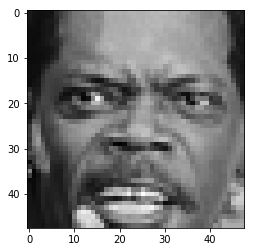

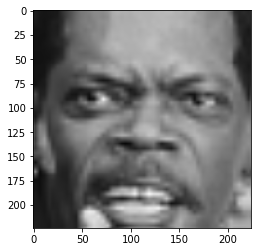

[1. 0. 0. 0. 0. 0. 0.]


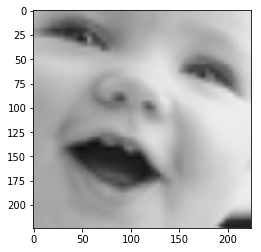

[0. 0. 0. 1. 0. 0. 0.]


In [12]:
i = 10
image = X_train[i,:,:,:].reshape(48, 48)
plt.imshow(image, cmap='gray')
plt.show()

image_resized = X_train_res[i,:,:,:].reshape(pixelsize, pixelsize, 3)
plt.imshow(image_resized)
plt.show()
print(Y_train_res[i])

dev_resized = X_dev_res[i,:,:,:].reshape(pixelsize, pixelsize, 3)
plt.imshow(dev_resized)
plt.show()
print(Y_dev_res[i])


In [13]:
print(sample.shape)
print(image_resized.shape)

(48, 48)
(224, 224, 3)


#Baseline model
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(48,48,1),name="input"),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv1"),
    Dropout(0.25), BatchNormalization(),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv2"),
    Dropout(0.25), BatchNormalization(),
    MaxPool2D(pool_size=(2,2),name="maxpool1"),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv3"),
    Dropout(0.25), BatchNormalization(),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv4"),
    Dropout(0.25), BatchNormalization(),
    Flatten(),
    Dense(1024,input_shape=(24*24*64,1),activation='relu',name='fc1'),
    Dense(7,input_shape=(1024,1),activation='softmax',name='fc-softmax')
])

print("Accuracy after training")
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=32, epochs=1, validation_data=(X_dev, Y_dev))

small_x = X_train_res[0:5000]
small_y = Y_train_res[0:5000]

In [14]:
history = custom_resnet.fit(
    X_train_res,
    Y_train_res,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(X_dev_res, Y_dev_res)
)

print('\nhistory dict:', history.history)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 656s 23ms/step - loss: 1.1518 - acc: 0.5916 - val_loss: 1.0869 - val_acc: 0.6250
Epoch 2/10
28709/28709 [==============================] - 611s 21ms/step - loss: 0.8232 - acc: 0.6941 - val_loss: 0.9561 - val_acc: 0.6559
Epoch 3/10
28709/28709 [==============================] - 611s 21ms/step - loss: 0.6897 - acc: 0.7447 - val_loss: 0.9195 - val_acc: 0.6726
Epoch 4/10
28709/28709 [==============================] - 611s 21ms/step - loss: 0.5628 - acc: 0.7962 - val_loss: 0.9387 - val_acc: 0.6801
Epoch 5/10
28709/28709 [==============================] - 611s 21ms/step - loss: 0.4480 - acc: 0.8378 - val_loss: 1.1717 - val_acc: 0.6411
Epoch 6/10
28709/28709 [==============================] - 611s 21ms/step - loss: 0.3401 - acc: 0.8799 - val_loss: 1.2257 - val_acc: 0.6425
Epoch 7/10
28709/2870

In [15]:
custom_resnet.save('transfer_learning.h5')

custom_resnet.evaluate(X_train_res, Y_train_res)

custom_resnet.evaluate(X_dev_res, Y_dev_res)